# 基于Actor-Critic，添加熵正则化

In [ ]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import matplotlib.pyplot as plt

# 设置随机种子
torch.manual_seed(42)
np.random.seed(42)

# 定义Actor-Critic网络
class ActorCritic(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.actor = nn.Linear(hidden_dim, output_dim)
        self.critic = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        action_probs = F.softmax(self.actor(x), dim=-1)
        value = self.critic(x)
        return action_probs, value

# 选择动作（添加熵计算）
def select_action(state, model, device):
    state = torch.FloatTensor(state).to(device)
    action_probs, value = model(state)
    m = Categorical(action_probs)
    action = m.sample()  # 张量
    log_prob = m.log_prob(action).unsqueeze(0)  # 转换为一维张量
    entropy = m.entropy().unsqueeze(0)  # 计算熵
    return action.item(), log_prob, value, entropy

# 训练函数（添加熵正则化）
def train(env, model, optimizer, device, num_episodes=1000, gamma=0.99, max_trajectory_length=500, entropy_beta=0.01, beta_schedule=False):
    episode_rewards = []
    actor_losses = []
    critic_losses = []
    entropies = []  # 记录平均熵
    
    for episode in range(num_episodes):
        # 动态调整 beta（可选）
        if beta_schedule:
            beta = entropy_beta * (1 - episode / num_episodes)  # 线性衰减到 0
        else:
            beta = entropy_beta
        
        state, _ = env.reset()
        log_probs = []
        values = []
        rewards = []
        next_states = []
        dones = []
        episode_entropies = []  # 每集的熵
        step_count = 0

        # 收集轨迹
        while True:
            action, log_prob, value, entropy = select_action(state, model, device)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated or (step_count >= max_trajectory_length - 1)
            
            log_probs.append(log_prob)
            values.append(value)
            rewards.append(reward)
            next_states.append(next_state)
            dones.append(done)
            episode_entropies.append(entropy)
            
            state = next_state
            step_count += 1
            if done:
                break
        
        # 计算 TD 目标和优势
        values = torch.cat(values)
        log_probs = torch.cat(log_probs)
        episode_entropies = torch.cat(episode_entropies)
        td_targets = []
        
        for t in range(len(rewards)):
            reward = rewards[t]
            if dones[t]:  # 终止状态、截断或达到最大长度
                target = torch.FloatTensor([reward]).to(device)
            else:
                next_state = torch.FloatTensor(next_states[t]).to(device)
                _, next_value = model(next_state)
                target = reward + gamma * next_value
            td_targets.append(target)
        
        td_targets = torch.cat(td_targets)
        advantage = td_targets - values
        
        # 计算损失（添加熵正则化）
        actor_loss = -(log_probs * advantage.detach()).mean()
        entropy_loss = -episode_entropies.mean()  # 负熵
        actor_loss = actor_loss + beta * entropy_loss
        critic_loss = advantage.pow(2).mean()
        loss = actor_loss + critic_loss
        
        # 记录损失和熵
        actor_losses.append(actor_loss.item())
        critic_losses.append(critic_loss.item())
        entropies.append(episode_entropies.mean().item())
        
        # 更新模型
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_reward = sum(rewards)
        episode_rewards.append(total_reward)
        
        if episode % 100 == 0:
            print(f"Episode {episode}, Total Reward: {total_reward:.2f}, Trajectory Length: {len(rewards)}")
            print(f"==> Total Loss: {loss:.4f}, Actor Loss: {actor_loss:.4f}, Critic Loss: {critic_loss:.4f}, Entropy Loss: {entropy_loss:.4f}, Avg Entropy: {entropies[-1]:.4f}, Beta: {beta:.4f}")
            print("# ------------------------------------------------- #")
    
    return episode_rewards, actor_losses, critic_losses, entropies

# 测试函数
def test(env, model, device, num_episodes=5, max_trajectory_length=500):
    model.eval()
    test_rewards = []
    for episode in range(num_episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False
        step_count = 0
        
        print(f"Testing Episode {episode + 1}/{num_episodes}")
        while not done:
            action, _, _, _ = select_action(state, model, device)
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated or (step_count >= max_trajectory_length - 1)
            total_reward += reward
            step_count += 1
            env.render()
            if done:
                break
        
        test_rewards.append(total_reward)
        print(f"Episode {episode + 1} Reward: {total_reward:.2f}, Length: {step_count}")
    
    avg_reward = np.mean(test_rewards)
    std_reward = np.std(test_rewards)
    return test_rewards, avg_reward, std_reward

# 评估和可视化（添加熵曲线）
def evaluate_and_plot(episode_rewards, actor_losses, critic_losses, entropies, test_rewards, avg_reward, std_reward):
    # 训练曲线（奖励、Actor 损失、Critic 损失、熵）
    plt.figure(figsize=(20, 5))
    
    plt.subplot(1, 4, 1)
    plt.plot(episode_rewards, label="Episode Reward", alpha=0.5)
    plt.plot(np.convolve(episode_rewards, np.ones(100)/100, mode='valid'), 
             label="Moving Avg (100)", color='red')
    plt.title("Training Reward Curve")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.legend()
    
    plt.subplot(1, 4, 2)
    plt.plot(actor_losses, label="Actor Loss", alpha=0.5)
    plt.plot(np.convolve(actor_losses, np.ones(100)/100, mode='valid'), 
             label="Moving Avg (100)", color='red')
    plt.title("Actor Loss Curve")
    plt.xlabel("Episode")
    plt.ylabel("Loss")
    plt.legend()
    
    plt.subplot(1, 4, 3)
    plt.plot(critic_losses, label="Critic Loss", alpha=0.5)
    plt.plot(np.convolve(critic_losses, np.ones(100)/100, mode='valid'), 
             label="Moving Avg (100)", color='red')
    plt.title("Critic Loss Curve")
    plt.xlabel("Episode")
    plt.ylabel("Loss")
    plt.legend()
    
    plt.subplot(1, 4, 4)
    plt.plot(entropies, label="Entropy", alpha=0.5)
    plt.plot(np.convolve(entropies, np.ones(100)/100, mode='valid'), 
             label="Moving Avg (100)", color='red')
    plt.title("Entropy Curve")
    plt.xlabel("Episode")
    plt.ylabel("Entropy")
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # 测试奖励直方图
    plt.figure(figsize=(5, 5))
    plt.hist(test_rewards, bins=20)
    plt.title(f'Test Rewards\nMean: {avg_reward:.2f}, Std: {std_reward:.2f}')
    plt.xlabel('Total Reward')
    plt.ylabel('Frequency')
    plt.show()

def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_env = gym.make("CartPole-v1")
    test_env = gym.make('CartPole-v1', render_mode='human')
    
    input_dim = train_env.observation_space.shape[0]
    hidden_dim = 128
    output_dim = train_env.action_space.n

    model = ActorCritic(input_dim, hidden_dim, output_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    print("Training...")
    episode_rewards, actor_losses, critic_losses, entropies = train(train_env, model, optimizer, device, num_episodes=1000, entropy_beta=0.01, beta_schedule=True)
    
    print("\nTesting with visualization...")
    test_rewards, avg_reward, std_reward = test(test_env, model, device)
    print(f"Average Test Reward: {avg_reward:.2f} ± {std_reward:.2f}")
    
    print("\nPlotting results...")
    evaluate_and_plot(episode_rewards, actor_losses, critic_losses, entropies, test_rewards, avg_reward, std_reward)
    
    train_env.close()
    test_env.close()

if __name__ == "__main__":
    main()

# 基于Actor-Critic,添加熵正则化 + N-Step优势估计

Training...
Episode 0, Total Reward: 13.00, Trajectory Length: 13
==> Total Loss: 80.4329, Actor Loss: 4.1298, Critic Loss: 38.1515, Entropy Loss: -0.6824, Avg Entropy: 0.6824, Beta: 0.0100
Advantage Mean: 5.7385, Std: 2.3784
# ------------------------------------------------- #
Episode 100, Total Reward: 12.00, Trajectory Length: 12
==> Total Loss: 44.7837, Actor Loss: 2.2840, Critic Loss: 21.2498, Entropy Loss: -0.6824, Avg Entropy: 0.6824, Beta: 0.0095
Advantage Mean: 3.1926, Std: 3.4730
# ------------------------------------------------- #
Episode 200, Total Reward: 15.00, Trajectory Length: 15
==> Total Loss: 30.5316, Actor Loss: 1.6179, Critic Loss: 14.4569, Entropy Loss: -0.6176, Avg Entropy: 0.6176, Beta: 0.0090
Advantage Mean: 2.0885, Std: 3.2888
# ------------------------------------------------- #
Episode 300, Total Reward: 44.00, Trajectory Length: 44
==> Total Loss: 42.7264, Actor Loss: 1.9755, Critic Loss: 20.3755, Entropy Loss: -0.6867, Avg Entropy: 0.6867, Beta: 0.0085


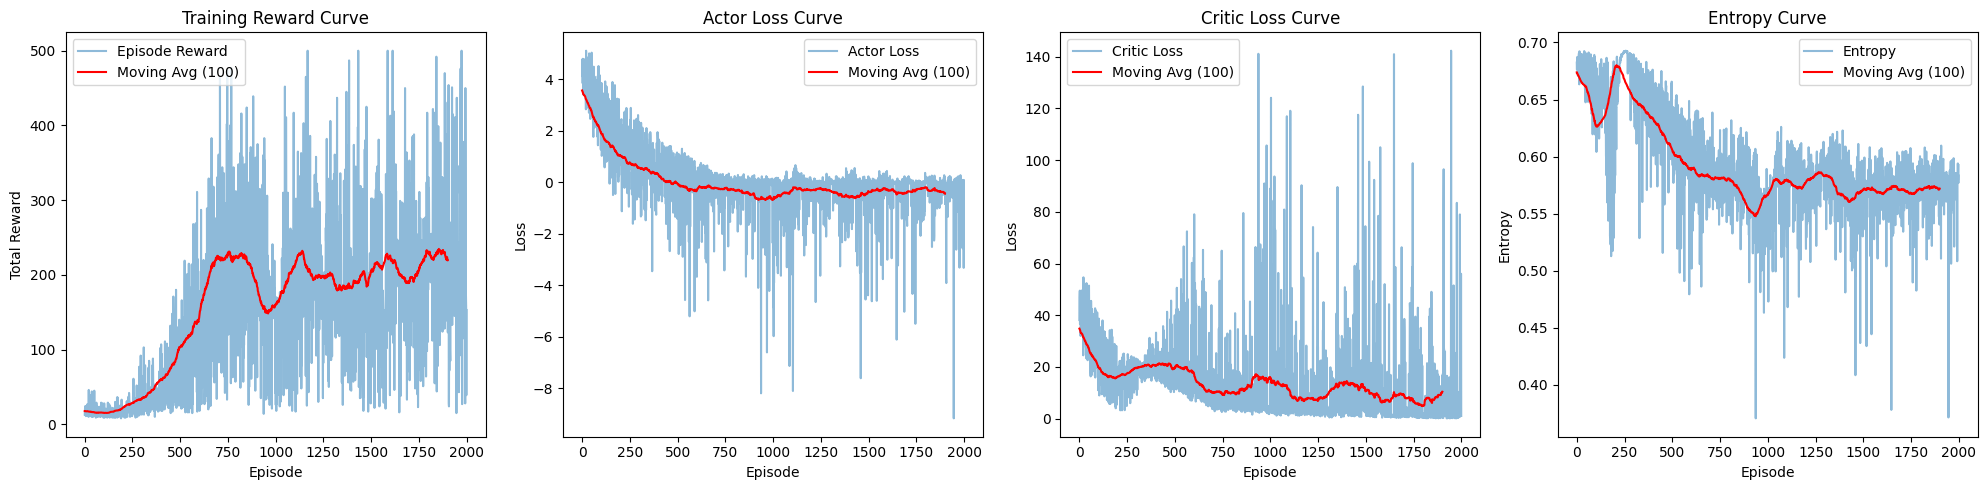

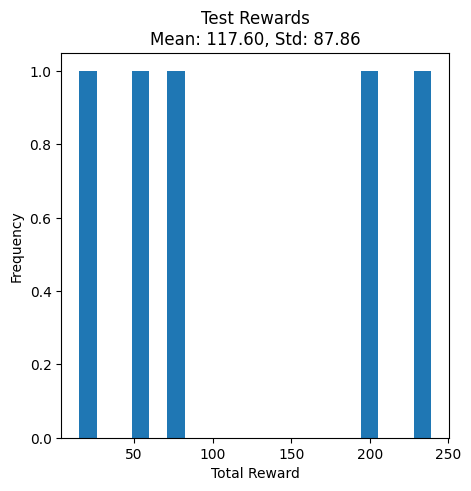

In [13]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import matplotlib.pyplot as plt

# 设置随机种子
torch.manual_seed(42)
np.random.seed(42)

# 定义Actor-Critic网络
class ActorCritic(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.actor = nn.Linear(hidden_dim, output_dim)
        self.critic = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        action_probs = F.softmax(self.actor(x), dim=-1)
        value = self.critic(x)
        return action_probs, value

# 选择动作
def select_action(state, model, device):
    state = torch.FloatTensor(state).to(device)
    action_probs, value = model(state)
    m = Categorical(action_probs)
    action = m.sample()
    log_prob = m.log_prob(action).unsqueeze(0)
    entropy = m.entropy().unsqueeze(0)
    return action.item(), log_prob, value, entropy

# 训练函数（修复 n-step 优势估计）
def train(env, model, optimizer, device, num_episodes=1000, gamma=0.95, max_trajectory_length=500, entropy_beta=0.01, beta_schedule=True, n_step=10):
    episode_rewards = []
    actor_losses = []
    critic_losses = []
    entropies = []
    
    for episode in range(num_episodes):
        # 动态调整 beta
        if beta_schedule:
            beta = entropy_beta * (1 - episode / num_episodes)
        else:
            beta = entropy_beta
        
        state, _ = env.reset()
        log_probs = []
        values = []
        rewards = []
        next_states = []
        dones = []
        episode_entropies = []
        step_count = 0
        
        # 收集轨迹
        while True:
            action, log_prob, value, entropy = select_action(state, model, device)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated or (step_count >= max_trajectory_length - 1)
            
            log_probs.append(log_prob)
            values.append(value)
            rewards.append(reward)
            next_states.append(next_state)
            dones.append(done)
            episode_entropies.append(entropy)
            
            state = next_state
            step_count += 1
            if done:
                break
        
        # 计算 n-step 回报和优势
        values = torch.cat(values)  # [T]
        log_probs = torch.cat(log_probs)  # [T, 1]
        episode_entropies = torch.cat(episode_entropies)  # [T, 1]
        td_targets = []
        
        T = len(rewards)
        for t in range(T):
            n_step_return = torch.tensor(0.0, device=device, dtype=torch.float32)
            max_steps = min(n_step, T - t)  # 最大可执行步数
            last_step = t + max_steps       # 实际终止位置
            
            # Step 1: 累积n-step奖励
            for i in range(max_steps):
                current_idx = t + i
                n_step_return += (gamma ** i) * rewards[current_idx]
                if dones[current_idx]:      # 遇到终止立即停止
                    last_step = current_idx + 1  # 标记实际终止位置
                    break
            
            # Step 2: 添加bootstrap值（仅当未终止且未越界时）
            if last_step < T and not dones[last_step - 1]:
                next_state_idx = min(t + n_step, T-1)  # 防止越界
                next_state = torch.FloatTensor(next_states[next_state_idx]).to(device)
                with torch.no_grad():  # 添加no_grad()
                    _, next_value = model(next_state)
                n_step_return += (gamma ** n_step) * next_value.squeeze()
            
            td_targets.append(n_step_return.unsqueeze(0))
        
        td_targets = torch.cat(td_targets)  # [T]
        advantage = td_targets - values  # [T]
        
        # # 归一化优势
        # advantage = (advantage - advantage.mean()) / (advantage.std() + 1e-8)
        
        # 计算损失
        actor_loss = -(log_probs.squeeze() * advantage.detach()).mean()
        entropy_loss = -episode_entropies.mean()
        actor_loss = actor_loss + beta * entropy_loss
        critic_loss = advantage.pow(2).mean()
        loss = actor_loss + 2 * critic_loss
        
        # 记录损失和熵
        actor_losses.append(actor_loss.item())
        critic_losses.append(critic_loss.item())
        entropies.append(episode_entropies.mean().item())
        
        # 更新模型
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        
        total_reward = sum(rewards)
        episode_rewards.append(total_reward)
        
        if episode % 100 == 0:
            print(f"Episode {episode}, Total Reward: {total_reward:.2f}, Trajectory Length: {len(rewards)}")
            print(f"==> Total Loss: {loss:.4f}, Actor Loss: {actor_loss:.4f}, Critic Loss: {critic_loss:.4f}, Entropy Loss: {entropy_loss:.4f}, Avg Entropy: {entropies[-1]:.4f}, Beta: {beta:.4f}")
            print(f"Advantage Mean: {advantage.mean().item():.4f}, Std: {advantage.std().item():.4f}")
            print("# ------------------------------------------------- #")
    
    return episode_rewards, actor_losses, critic_losses, entropies

# 测试函数
def test(env, model, device, num_episodes=5, max_trajectory_length=500):
    model.eval()
    test_rewards = []
    for episode in range(num_episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False
        step_count = 0
        
        print(f"Testing Episode {episode + 1}/{num_episodes}")
        while not done:
            action, _, _, _ = select_action(state, model, device)
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated or (step_count >= max_trajectory_length - 1)
            total_reward += reward
            step_count += 1
            env.render()
            if done:
                break
        
        test_rewards.append(total_reward)
        print(f"Episode {episode + 1} Reward: {total_reward:.2f}, Length: {step_count}")
    
    avg_reward = np.mean(test_rewards)
    std_reward = np.std(test_rewards)
    return test_rewards, avg_reward, std_reward

# 评估和可视化
def evaluate_and_plot(episode_rewards, actor_losses, critic_losses, entropies, test_rewards, avg_reward, std_reward):
    plt.figure(figsize=(20, 5))
    
    plt.subplot(1, 4, 1)
    plt.plot(episode_rewards, label="Episode Reward", alpha=0.5)
    plt.plot(np.convolve(episode_rewards, np.ones(100)/100, mode='valid'), 
             label="Moving Avg (100)", color='red')
    plt.title("Training Reward Curve")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.legend()
    
    plt.subplot(1, 4, 2)
    plt.plot(actor_losses, label="Actor Loss", alpha=0.5)
    plt.plot(np.convolve(actor_losses, np.ones(100)/100, mode='valid'), 
             label="Moving Avg (100)", color='red')
    plt.title("Actor Loss Curve")
    plt.xlabel("Episode")
    plt.ylabel("Loss")
    plt.legend()
    
    plt.subplot(1, 4, 3)
    plt.plot(critic_losses, label="Critic Loss", alpha=0.5)
    plt.plot(np.convolve(critic_losses, np.ones(100)/100, mode='valid'), 
             label="Moving Avg (100)", color='red')
    plt.title("Critic Loss Curve")
    plt.xlabel("Episode")
    plt.ylabel("Loss")
    plt.legend()
    
    plt.subplot(1, 4, 4)
    plt.plot(entropies, label="Entropy", alpha=0.5)
    plt.plot(np.convolve(entropies, np.ones(100)/100, mode='valid'), 
             label="Moving Avg (100)", color='red')
    plt.title("Entropy Curve")
    plt.xlabel("Episode")
    plt.ylabel("Entropy")
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(5, 5))
    plt.hist(test_rewards, bins=20)
    plt.title(f'Test Rewards\nMean: {avg_reward:.2f}, Std: {std_reward:.2f}')
    plt.xlabel('Total Reward')
    plt.ylabel('Frequency')
    plt.show()

def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_env = gym.make("CartPole-v1")
    test_env = gym.make('CartPole-v1', render_mode='human')
    
    input_dim = train_env.observation_space.shape[0]
    hidden_dim = 128
    output_dim = train_env.action_space.n

    model = ActorCritic(input_dim, hidden_dim, output_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    print("Training...")
    episode_rewards, actor_losses, critic_losses, entropies = train(train_env, model, optimizer, device, num_episodes=2000, n_step=10)
    
    print("\nTesting with visualization...")
    test_rewards, avg_reward, std_reward = test(test_env, model, device)
    print(f"Average Test Reward: {avg_reward:.2f} ± {std_reward:.2f}")
    
    print("\nPlotting results...")
    evaluate_and_plot(episode_rewards, actor_losses, critic_losses, entropies, test_rewards, avg_reward, std_reward)
    
    train_env.close()
    test_env.close()

if __name__ == "__main__":
    main()